In [ ]:
import typing as t
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

from IPython.display import clear_output

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
images = np.load('olivetti_faces.npy')

In [ ]:
images[359].shape

(64, 64)

In [ ]:
targets = np.load('olivetti_faces_target.npy')

In [ ]:
len(np.unique(targets))
#40 классов

40

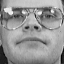

In [ ]:
im = Image.fromarray(images[359] * 256)
new_im = im.convert('RGB')

display(new_im)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cpu device


In [ ]:
def is_colab() -> bool:
    return DEVICE == "cuda"

def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        verbose: int = 100,
        test_dataloader: DataLoader = None,
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, verbose)
        train_losses.append(train_loss.item())
        if test_dataloader:
            test_loop(test_dataloader, model, loss_fn)
    return train_losses

#train и test_loop берем из первой части задания
def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        x, y = x.to(DEVICE), y.to(DEVICE)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            y = y.type(torch.LongTensor)
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy

class FastDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

        n = len(self.dataset)
        x, _ = self.dataset[0]
        self._data = torch.empty(n, *x.size(), dtype=x.dtype)
        self._targets = [0] * n
        for i, (x, y) in tqdm(enumerate(self.dataset), total=n):
            self._data[i] = x
            self._targets[i] = y

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self._data[idx], self._targets[idx]

#рисуем графики
def plot_losses(train_losses):
    fig = plt.figure(figsize=(8, 5))

    plt.plot(torch.arange(len(train_losses)), train_losses, color='#4FC2EB')
    plt.xlabel('Epochs', fontsize = 15)
    plt.ylabel('Test loss', fontsize = 15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #plt.legend(fontsize = 15)
    plt.savefig('classical_MLP_test_accuracy.pdf')
    plt.show()

#на случай, если придется выводить результаты слоев
def _color_imshow(img):
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1))


def _gray_imshow(img):
    plt.imshow(img.squeeze(), cmap="gray")

#выводим предсказания с картинками
def visualize_predicts(model: nn.Module,
        dataset: Dataset,
        classes,
        imshow=_color_imshow,
        amount=5
):
    model.eval()

    fig = plt.figure(figsize=(8, 18))

    for sample in range(1, amount+1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()  # noqa
      img, true_label = dataset[sample_idx]

      pred = model(img.unsqueeze(0).to(DEVICE))
      pred_proba = F.softmax(pred, 1).max(1).values.item()
      pred_label = pred.argmax(1).item()


      fig.add_subplot(1, amount, sample)
      plt.title(f"pred: {classes[pred_label]} ({pred_proba:.2f})"
            f"\ntrue: {classes[true_label]}")
      plt.axis("off")
      imshow(img.cpu())

#матрца ошибок
def plot_confusion_matrix(y_true, y_pred, classes):
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=classes,
        xticks_rotation=45,
        cmap=sns.color_palette("magma", as_cmap=True),
        colorbar=False,
    )
    cm_display.ax_.grid(False)
    cm_display.figure_.set_size_inches(9, 9)


def get_y_test_y_pred_batches(model: nn.Module, test_dataloader: DataLoader):
    model.eval()

    y_test = []
    y_pred = []
    for x, y in test_dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x).argmax(1)
        y_test.append(y)
        y_pred.append(pred)

    return torch.hstack(y_test).detach().cpu(), torch.hstack(y_pred).detach().cpu()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize(size=(100, 100)),  
    #transforms.ToTensor(),
])

torch_data = torch.zeros([1, 400, 64, 64])
print(torch_data.shape)

temp_tensor = torch.Tensor(images*1)
print(temp_tensor.shape)
torch_data[0] =  temp_tensor
torch_targets = torch.Tensor(targets)

torch_data = torch.transpose(torch_data, 0, 1)

norm  = transforms.Normalize(mean = 0.5, std = 0.25)

torch_data = norm(torch_data)

#resize = transforms.Resize(size = (160, 160))

#torch_data = resize(torch_data)

print(torch_data.shape)

faces_dataset = TensorDataset(torch_data,torch_targets)

train_size = round(0.65 * len(faces_dataset))

train_faces_dataset, test_faces_dataset = random_split(
    faces_dataset,
    lengths=(train_size, len(faces_dataset) - train_size),
)

(
    (len(train_faces_dataset), len(test_faces_dataset)),
    train_faces_dataset[0][0].shape,
)

torch.Size([1, 400, 64, 64])
torch.Size([400, 64, 64])
torch.Size([400, 1, 64, 64])


((260, 140), torch.Size([1, 64, 64]))

In [ ]:
train_faces_dataset

In [ ]:
fast_train_faces_dataset = FastDataset(train_faces_dataset)
fast_test_faces_dataset = FastDataset(test_faces_dataset)

100%|██████████| 140/140 [00:00<00:00, 10997.74it/s]


In [ ]:
#попробуем сначала хоть что-то
class faces_cnn(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(faces_cnn, self).__init__()

        self.features = nn.Sequential(OrderedDict({
            "conv0": nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=5, stride=2, padding=1, bias = False),
            "norm0": nn.BatchNorm2d(16),
            "relu0": nn.ReLU(True),
            #"maxpool0": nn.MaxPool2d(2),
            "conv1": nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias = False),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            #"maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, bias = False),
            "norm2": nn.BatchNorm2d(64),
            "relu2": nn.ReLU(True),
            #"maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((12, 12))
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(64 * 12 * 12, 1024),
            "elu1": nn.ReLU(inplace=True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(1024, 256),
            "elu2": nn.ReLU(inplace=True),
            #"drop2": nn.Dropout(),
            "fc3": nn.Linear(256, 1024),
            "elu3": nn.ReLU(inplace=True),
            #"drop3": nn.Dropout(),
            "fc4": nn.Linear(1024, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
torch.manual_seed(7)

net = faces_cnn(1, 40).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

faces_train_dataloader = DataLoader(
    fast_train_faces_dataset,
    batch_size=40,
    shuffle=True,
    num_workers=2 if is_colab() else 0,
)
faces_test_dataloader = DataLoader(
    fast_test_faces_dataset,
    batch_size=len(fast_test_faces_dataset),
    num_workers=2 if is_colab() else 0,
)

net

faces_cnn(
  (features): Sequential(
    (conv0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(12, 12))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=1024, bias=True)
    (elu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (elu2): ReLU(inplace=True)
    (fc3): 

In [ ]:
%%time

train_losses = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=faces_train_dataloader,
    epochs=15,
    verbose=2,
    test_dataloader=faces_test_dataloader,
)

Epoch 1
--------------------------------
loss: 3.690343  [    0/  260]
loss: 3.858706  [   80/  260]
loss: 3.770604  [  160/  260]
loss: 3.803655  [  120/  260]
Test Error: 
 Accuracy: 0.007143, Avg loss: 3.694765 

Epoch 2
--------------------------------
loss: 3.447314  [    0/  260]
loss: 3.767853  [   80/  260]
loss: 3.333197  [  160/  260]
loss: 3.429833  [  120/  260]
Test Error: 
 Accuracy: 0.121429, Avg loss: 3.516656 

Epoch 3
--------------------------------
loss: 3.000108  [    0/  260]
loss: 2.753914  [   80/  260]
loss: 3.037961  [  160/  260]
loss: 2.281692  [  120/  260]
Test Error: 
 Accuracy: 0.250000, Avg loss: 2.983957 

Epoch 4
--------------------------------
loss: 2.166315  [    0/  260]
loss: 2.441931  [   80/  260]
loss: 1.904187  [  160/  260]
loss: 1.653272  [  120/  260]
Test Error: 
 Accuracy: 0.450000, Avg loss: 2.175874 

Epoch 5
--------------------------------
loss: 1.368491  [    0/  260]
loss: 1.015357  [   80/  260]
loss: 1.216802  [  160/  260]
loss:

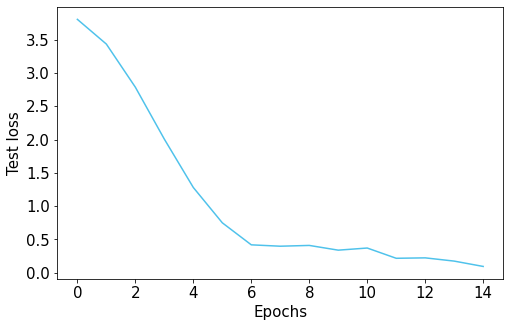

In [ ]:
plot_losses(train_losses);

In [ ]:
test_loop(faces_test_dataloader, net, loss_fn);

Test Error: 
 Accuracy: 0.814286, Avg loss: 0.731777 



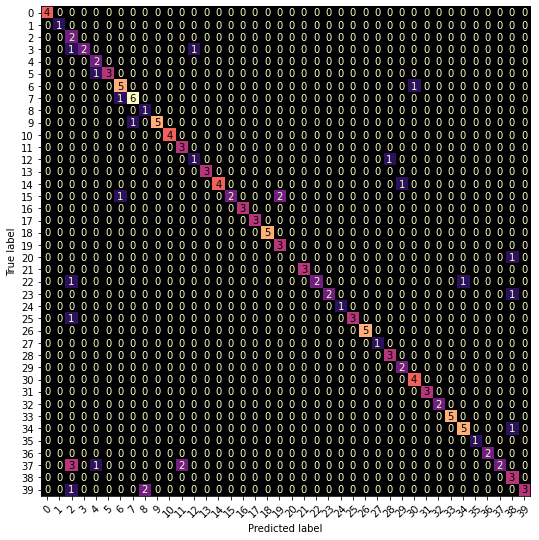

In [ ]:
y_test, y_pred = get_y_test_y_pred_batches(
    model=net,
    test_dataloader=faces_test_dataloader,
)
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    classes=np.arange(40),
);

In [ ]:
print(metrics.classification_report(y_test.cpu(), y_pred.cpu()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         1
         2.0       0.22      1.00      0.36         2
         3.0       1.00      0.50      0.67         4
         4.0       0.50      1.00      0.67         2
         5.0       1.00      0.75      0.86         4
         6.0       0.71      0.83      0.77         6
         7.0       0.86      0.86      0.86         7
         8.0       0.33      1.00      0.50         1
         9.0       1.00      0.83      0.91         6
        10.0       1.00      1.00      1.00         4
        11.0       0.60      1.00      0.75         3
        12.0       0.50      0.50      0.50         2
        13.0       1.00      1.00      1.00         3
        14.0       1.00      0.80      0.89         5
        15.0       1.00      0.40      0.57         5
        16.0       1.00      1.00      1.00         3
        17.0       1.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
